<a href="https://colab.research.google.com/gist/gretahartm/f73feb0f0d5baa2430978f5fb00aeffc/7notebooksb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmentation to coordinates

In [1]:
!pip install albumentations==1.3.0
!git clone https://github.com/kevin-allen/unetTracker
!pip install -r unetTracker/requirements.txt
!pip install -e unetTracker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20
Cloning into 'unetTracker'...
remote: Enumerating objects: 1022, done.
remote: Counting objects: 100% (401/401), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 1022 (delta 233), reused 353 (delta 204), pack-reused 621 (from 1)
Receiving objects: 100% (1022/1022), 127.56 MiB | 16.97 MiB/s, done.
Resolving deltas: 100% (623/623), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

fn = "/content/drive/My Drive/ssfolder"
if os.path.exists(fn):
  print("We can access the ssfolder directory.")
else:
  raise IOError("Problem accessing the ssfolder directory.")

Mounted at /content/drive
We can access the ssfolder directory.


In [3]:
# this will run the code in the setup_project.py and create a variable called `project`
fn = "/content/drive/My Drive/ssfolder/setup_project.py"
if os.path.exists(fn):
  print("We can access the file.")
else:
  raise IOError("Problem accessing the file.")

%run "/content/drive/My Drive/ssfolder/setup_project.py"

We can access the file.
Project directory: /content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker
Getting configuration from config file. Values from config file will be used.
Loading /content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker/config.yalm
{'augmentation_HorizontalFlipProb': 0.5, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_extension': '.png', 'image_size': [270, 480], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'simonebiles_tracker', 'normalization_values': {'means': [0.1952759027481079, 0.15899455547332764, 0.13951754570007324], 'stds': [0.16387943923473358, 0.16304421424865723, 0.16733983159065247]}, 'object_colors': [(240.0, 248.0, 255.0), (250.0, 235.0, 215.0), (0.0, 255.0, 255.0), (127.0, 255.0, 212.0), (240.0, 255.0, 255.0), (245.0, 245.0, 220.0), (255.0, 228.0, 196.0), (0.0, 0.0, 0.0), (255.0, 235.0, 205.0), (0.0, 0.0, 255.0)], 'objects': ['head', 'right

In [4]:
import torch
import albumentations as A
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet

In [5]:
VAL_IMAGE_DIR = os.path.join(project.dataset_dir,"val_images")
VAL_MASK_DIR =  os.path.join(project.dataset_dir,"val_masks")
VAL_COORDINATE_DIR = os.path.join(project.dataset_dir,"val_coordinates")
DEVICE = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

In [6]:
fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Loading valTransform from", fileName)
valTransform=pickle.load(open(fileName, "rb" ))
print(valTransform)

Loading valTransform from /content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker/augmentation/valTransform
Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.1952759027481079, 0.15899455547332764, 0.13951754570007324], std=[0.16387943923473358, 0.16304421424865723, 0.16733983159065247], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [7]:
valDataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=valTransform,image_extension=project.image_extension)
dataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=None,image_extension=project.image_extension)

In [8]:
model = Unet(in_channels=3, out_channels=len(project.object_list)).to(DEVICE)
project.load_model(model)
a = model.eval()

/content/drive/My Drive/ssfolder/unetTracker/trackingProject.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.model_fn))


In [9]:
imageIndex=6
image,mask,coord = valDataset[imageIndex]
imageOri,_,_ =dataset[imageIndex]

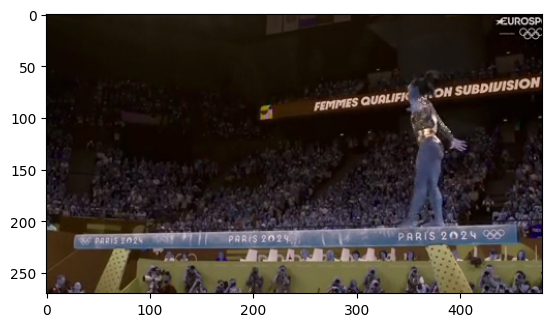

In [10]:
imageOri =imageOri.permute(1,2,0).numpy()
imageOri = imageOri.astype(np.uint8)
plt.imshow(imageOri)

In [11]:
img = image.permute(1,2,0).numpy() #
msk = mask.numpy()

#Image and masks for an item of the validation set

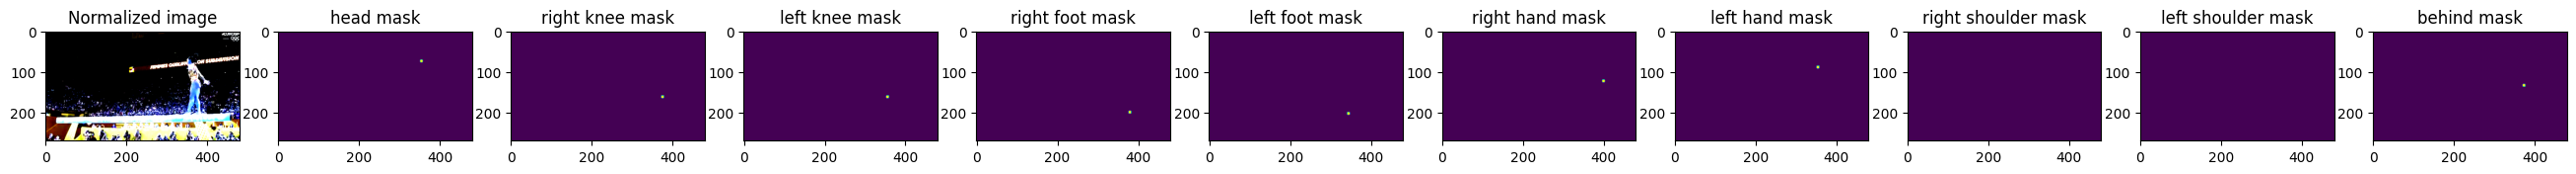

In [12]:
fig, ax = plt.subplots(1,msk.shape[0]+1,figsize=((msk.shape[0]+1)*3,3))
ax[0].imshow(img)
ax[0].set_title("Normalized image")
for i in range(msk.shape[0]):
    ax[i+1].imshow(msk[i])
    ax[i+1].set_title(project.object_list[i]+" mask")

#Image and mask predictions of an item of the validation set

In [13]:
%%time

image,mask,coord = valDataset[imageIndex]
image = image.unsqueeze(0).to(DEVICE)
output = torch.sigmoid(model(image))
output = output.detach().cpu().numpy()

CPU times: user 221 ms, sys: 112 ms, total: 332 ms
Wall time: 899 ms


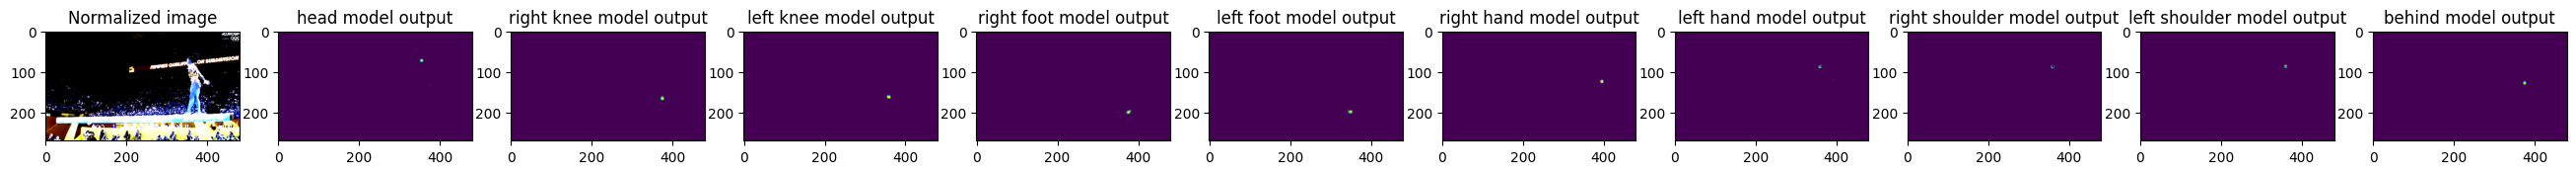

In [14]:
fig, ax = plt.subplots(1,output.shape[1]+1,figsize=((output.shape[1]+1)*3,3))
ax[0].imshow(img)
ax[0].set_title("Normalized image")
for i in range(output.shape[1]):
    ax[i+1].imshow(output[0,i])
    ax[i+1].set_title(project.object_list[i]+" model output")

#Extracting coordinate out of the mask

In [15]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 30 # 100 # between 400 and 500 is the decision point
detector = cv2.SimpleBlobDetector_create(params)

In [16]:
blobs = imageOri.astype(np.uint8)
nObjects = output.shape[1]
pred = np.empty((output.shape[0],nObjects,3)) # x, y, probability
pred[:,:,:] = np.nan
pred[:,:,2] = output.reshape(nObjects,-1).max(axis=1) # maximal value in each object mask

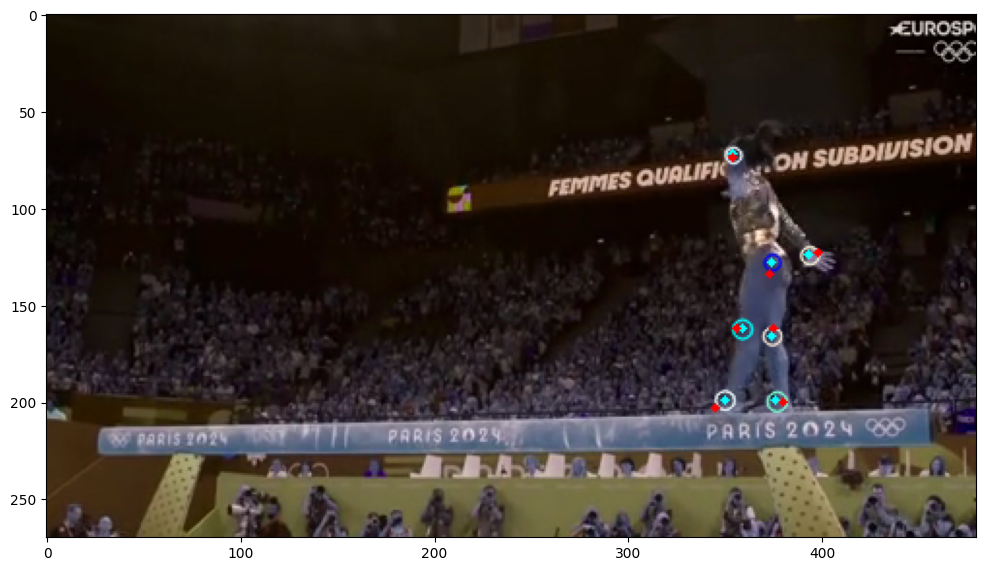

[[[3.54435791e+02 7.29384689e+01 9.89152789e-01]
  [3.74491180e+02 1.66103439e+02 9.95936513e-01]
  [3.59050720e+02 1.62576141e+02 9.95759547e-01]
  [3.76907074e+02 1.99865479e+02 9.72541034e-01]
  [3.50049469e+02 1.99209732e+02 9.89127219e-01]
  [3.93905273e+02 1.24582634e+02 9.97267246e-01]
  [           nan            nan 7.24181384e-02]
  [           nan            nan 1.35579407e-02]
  [           nan            nan 4.96603578e-01]
  [3.74582764e+02 1.28195648e+02 9.54279482e-01]]]
[[354.  74.]
 [375. 162.]
 [356. 162.]
 [380. 200.]
 [345. 203.]
 [398. 123.]
 [353.  89.]
 [ nan  nan]
 [ nan  nan]
 [373. 134.]]


array([1.14750251, 4.13486538, 3.10464695, 3.09585003, 6.31373647,
       4.38993347,        nan,        nan,        nan, 6.0162813 ])

In [17]:
for item in range(1):
    for objectIndex in range(len(project.object_list)):

        out = output[item]
        outputT = np.expand_dims((out[objectIndex]*255).astype(np.uint8),2) # get output in unsigned int 8 format, values ranging from 0 to 255
        outputT= 255-outputT # reverse values because the SimpleBlobDetector is looking for dark blob


        keypoints = detector.detect(outputT)
        if keypoints:
            blank = np.zeros((1, 1))
            blobs = cv2.drawKeypoints(blobs, keypoints, blank, project.object_colors[objectIndex],cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            # find the largest blob
            largest_size=0
            pt = None
            for k in keypoints:
                if k.size>largest_size:
                    pt = k.pt
            pred[item,objectIndex,0] = pt[0]
            pred[item,objectIndex,1] = pt[1]
            cv2.circle(blobs,(int(pt[0]),int(pt[1])), 2, (0,255,255), -1)
            cv2.circle(blobs,(int(coord[objectIndex,0]),int(coord[objectIndex,1])), 2, (255,0,0), -1)
    plt.figure(figsize=(12,12))
    plt.imshow(blobs)
    plt.show()

print(pred)
print(coord)
# distance between predicted coordinates and labeled coordinates
np.sqrt(np.sum((coord-pred[0,:,0:2])**2,axis=1))

#CoordinatesFromSegmentationMask object

In [18]:
image,mask,coord = valDataset[imageIndex]
image = image.unsqueeze(0).to(DEVICE)
output = torch.sigmoid(model(image))
output = output.detach().cpu().numpy()

In [19]:
from unetTracker.coordinatesFromSegmentationMask import CoordinatesFromSegmentationMask
cDetector = CoordinatesFromSegmentationMask()

In [20]:
pred = cDetector.detect(output)

In [21]:
pred , coord

(array([[[3.54437378e+02, 7.29295197e+01, 9.89152789e-01],
         [3.74507202e+02, 1.66107895e+02, 9.95936513e-01],
         [3.59026031e+02, 1.62547775e+02, 9.95759547e-01],
         [3.76880341e+02, 1.99892883e+02, 9.72541034e-01],
         [3.50244598e+02, 1.99156525e+02, 9.89127219e-01],
         [3.93927124e+02, 1.24601128e+02, 9.97267246e-01],
         [           nan,            nan, 7.24181384e-02],
         [           nan,            nan, 1.35579407e-02],
         [           nan,            nan, 4.96603578e-01],
         [3.74546112e+02, 1.28187271e+02, 9.54279482e-01]]]),
 array([[354.,  74.],
        [375., 162.],
        [356., 162.],
        [380., 200.],
        [345., 203.],
        [398., 123.],
        [353.,  89.],
        [ nan,  nan],
        [ nan,  nan],
        [373., 134.]]))

#Processing image from a video

In [22]:
video_fn = '/content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker/videos/simonebiles.mp4'

Number of frames in /content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker/videos/simonebiles.mp4: 3327
frame 139


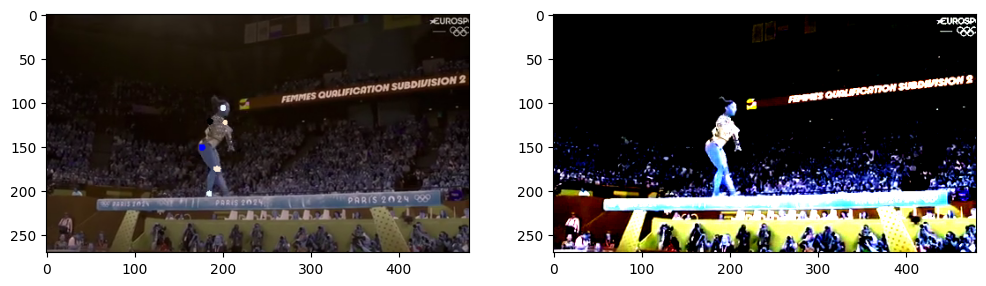

[[[2.00555771e+02 1.05995705e+02 9.73088324e-01]
  [1.93842499e+02 1.75346420e+02 9.24078286e-01]
  [           nan            nan 5.15586920e-02]
  [           nan            nan 1.09616764e-01]
  [1.84876160e+02 2.03255295e+02 9.48938847e-01]
  [2.10381454e+02 1.50550995e+02 4.66704160e-01]
  [           nan            nan 3.98304733e-03]
  [1.85635452e+02 1.21286186e+02 9.81464565e-01]
  [2.02826202e+02 1.22524551e+02 8.51190627e-01]
  [1.76634354e+02 1.50722610e+02 9.97264147e-01]]]
frame 561


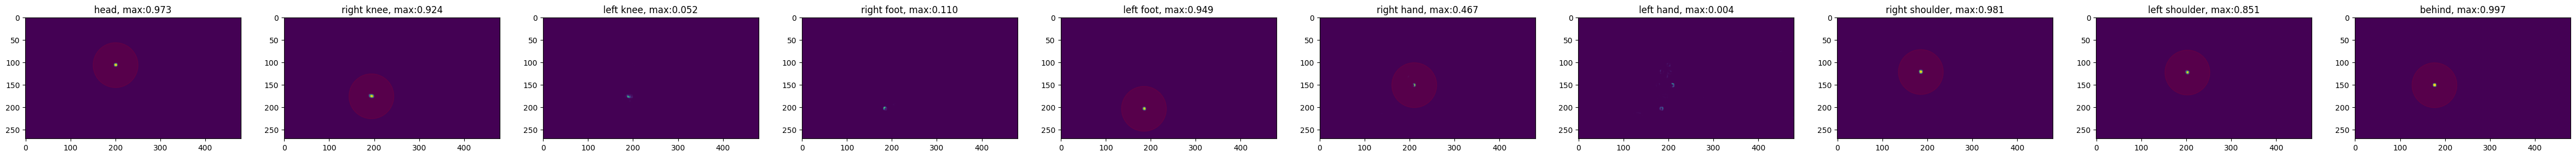

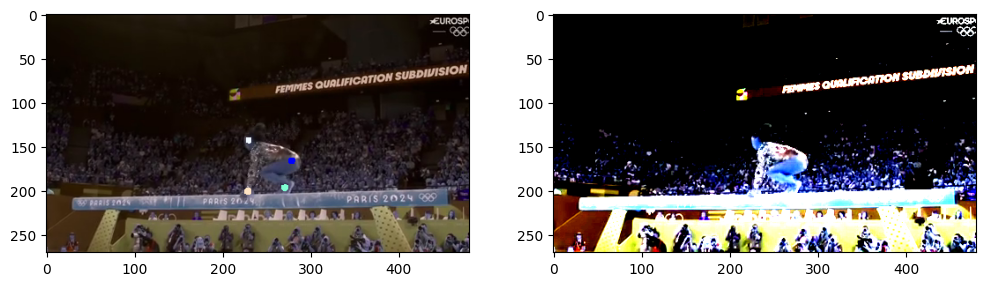

[[[2.29497070e+02 1.42656616e+02 9.91465271e-01]
  [           nan            nan 4.24707755e-02]
  [           nan            nan 2.29540211e-03]
  [2.70461456e+02 1.96486252e+02 9.87288475e-01]
  [2.66827667e+02 1.98141373e+02 3.54178160e-01]
  [           nan            nan 8.39068219e-02]
  [2.28711212e+02 2.00468307e+02 9.99374092e-01]
  [           nan            nan 2.72492468e-02]
  [2.39556747e+02 1.53587585e+02 3.44882876e-01]
  [2.78391449e+02 1.65936859e+02 9.94088054e-01]]]
frame 619


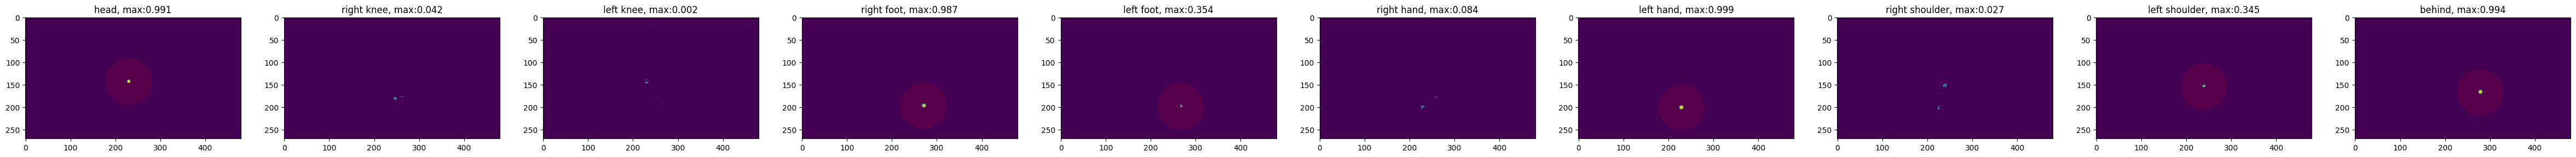

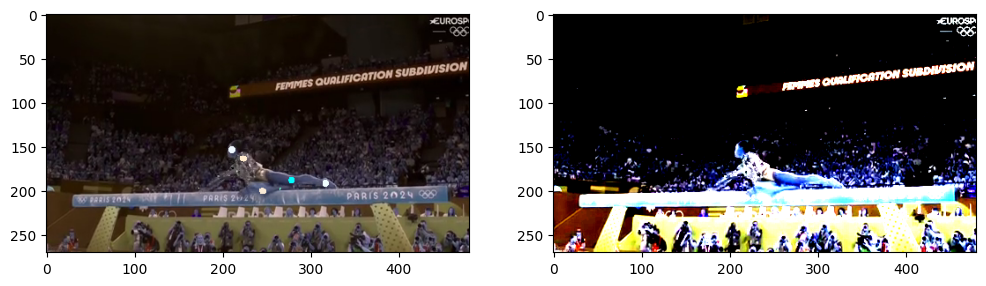

[[[2.10465637e+02 1.53526794e+02 9.99340951e-01]
  [2.45469131e+02 2.00211197e+02 9.96816099e-01]
  [2.78156525e+02 1.87856644e+02 9.53044295e-01]
  [2.65167694e+02 1.97542953e+02 5.52883208e-01]
  [3.16629120e+02 1.91450729e+02 9.95595396e-01]
  [1.73744492e+02 1.97137131e+02 5.51311851e-01]
  [           nan            nan 1.78743258e-01]
  [2.11078857e+02 1.74878036e+02 6.15381837e-01]
  [2.23412552e+02 1.63534622e+02 9.93745029e-01]
  [           nan            nan 8.82541295e-03]]]
frame 1148


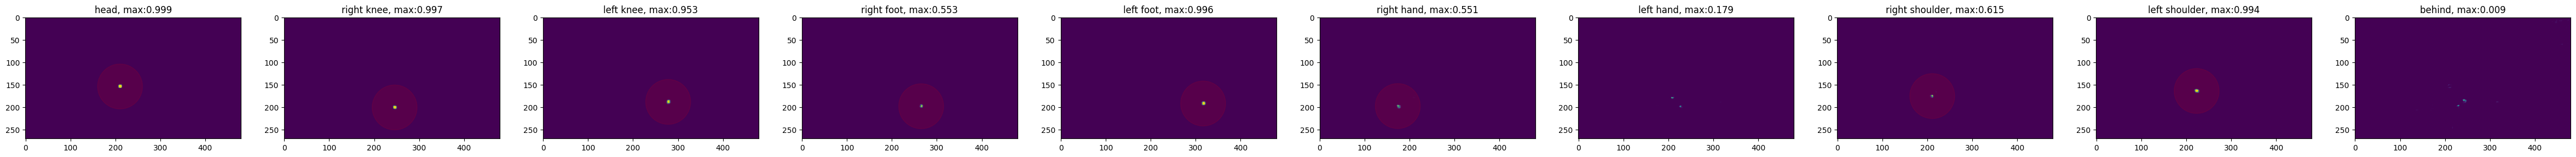

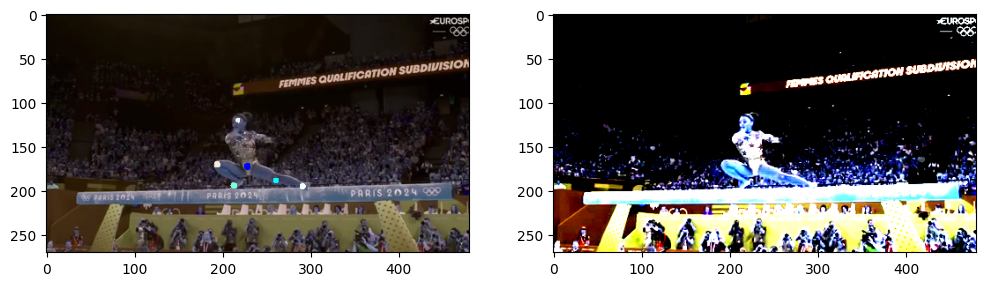

[[[2.17229080e+02 1.20272057e+02 9.13839400e-01]
  [1.93809952e+02 1.70308243e+02 9.92449045e-01]
  [2.60556702e+02 1.88317184e+02 9.65658665e-01]
  [2.12725540e+02 1.94079422e+02 9.76391613e-01]
  [2.90720093e+02 1.95079880e+02 9.35046434e-01]
  [           nan            nan 1.21085970e-02]
  [           nan            nan 1.01573346e-02]
  [           nan            nan 7.28040040e-02]
  [           nan            nan 2.98173148e-02]
  [2.28197754e+02 1.72454010e+02 9.75716352e-01]]]
frame 1472


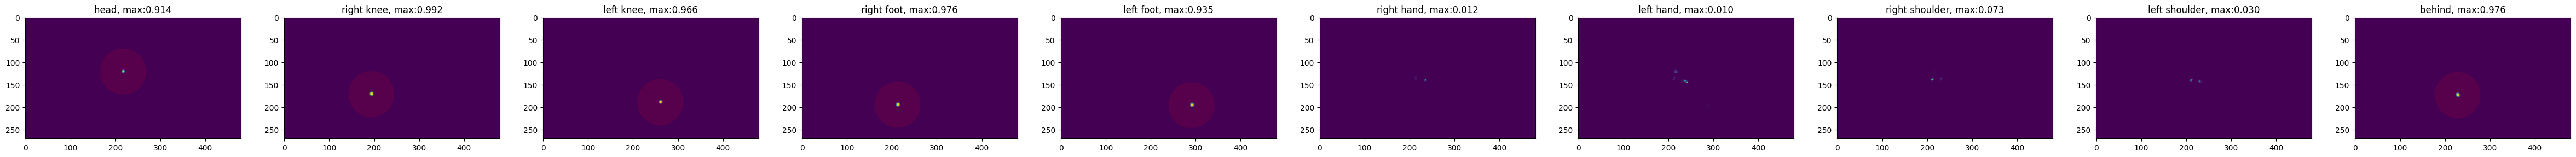

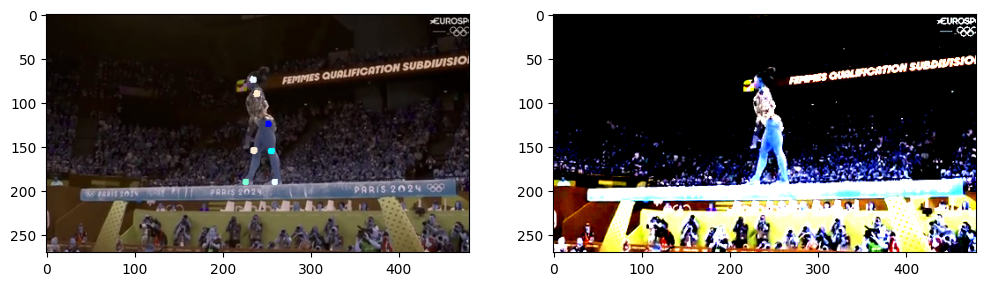

[[[2.34625565e+02 7.37224426e+01 9.99766767e-01]
  [2.35528763e+02 1.54280243e+02 9.94160593e-01]
  [2.55382675e+02 1.54996902e+02 9.99669313e-01]
  [2.26317581e+02 1.89751938e+02 9.97928977e-01]
  [2.59135162e+02 1.89787796e+02 9.93186831e-01]
  [           nan            nan 5.94157027e-03]
  [           nan            nan 4.03780490e-02]
  [           nan            nan 1.03816492e-02]
  [2.38810440e+02 8.97421646e+01 9.98101175e-01]
  [2.51849945e+02 1.24151878e+02 9.87675905e-01]]]
frame 1863


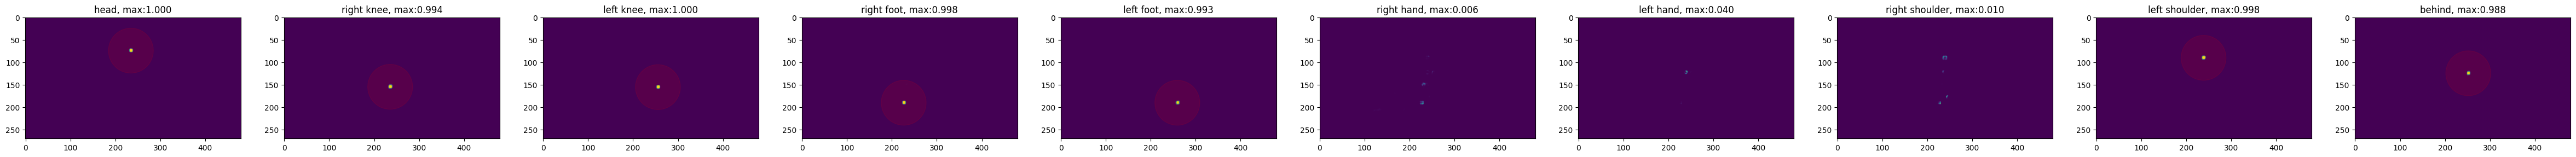

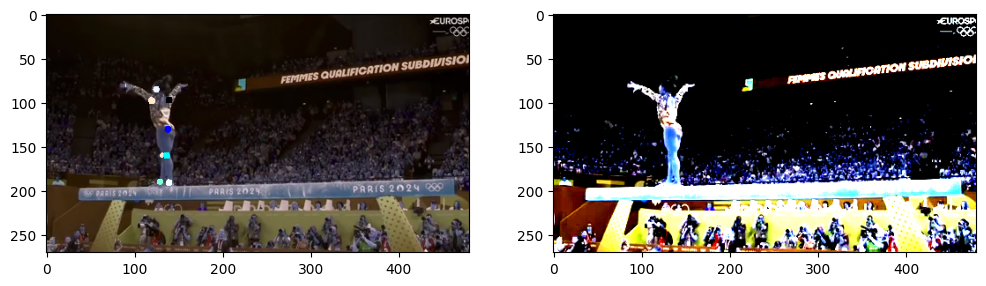

[[[1.24668518e+02 8.48912659e+01 9.94305909e-01]
  [1.31195892e+02 1.59856354e+02 7.98466206e-01]
  [1.36486404e+02 1.60119522e+02 9.95544374e-01]
  [1.28996826e+02 1.89701843e+02 9.82838452e-01]
  [1.39256027e+02 1.90796829e+02 9.99282539e-01]
  [           nan            nan 7.33908564e-02]
  [9.01795654e+01 8.07280731e+01 5.45775890e-01]
  [1.39018784e+02 9.72026062e+01 9.95053589e-01]
  [1.19599594e+02 9.77908707e+01 9.99361813e-01]
  [1.37827515e+02 1.30421738e+02 9.95966792e-01]]]
frame 1892


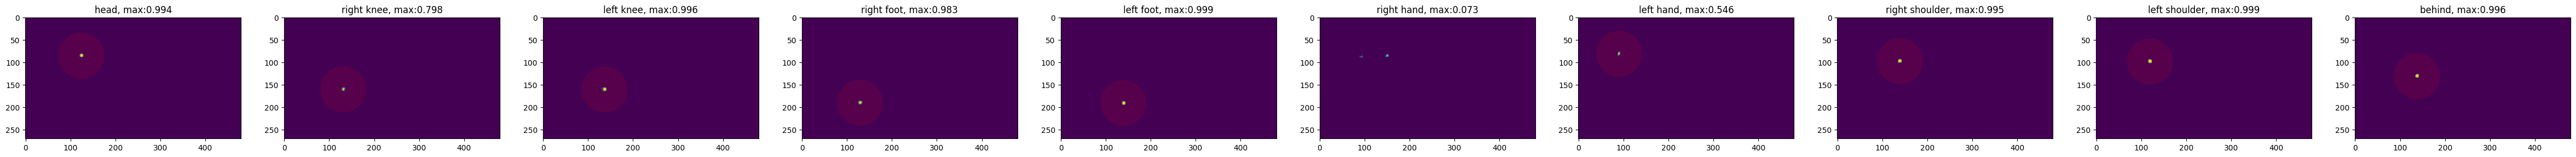

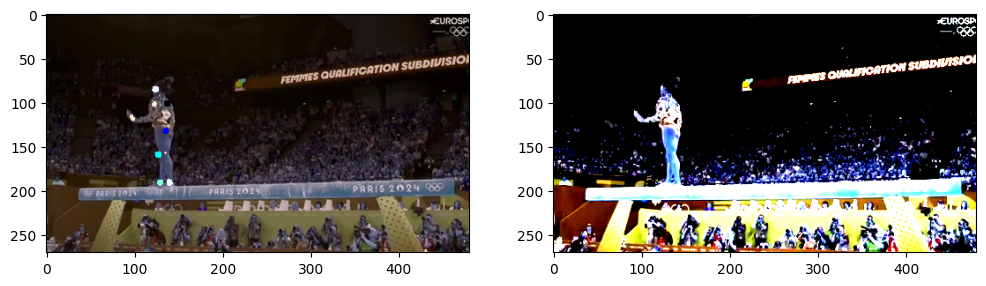

[[[123.71453857  84.68177032   0.98969626]
  [134.89157104 157.47999573   0.61501485]
  [126.92671967 158.93899536   0.98388517]
  [129.14700317 190.53948975   0.97967529]
  [139.50160217 190.6476593    0.99945766]
  [ 98.22533417 118.64650726   0.77987212]
  [ 96.56145477 115.97211456   0.82837957]
  [136.92127991 101.07928467   0.98898613]
  [122.45963287 101.68148041   0.9923023 ]
  [135.81236267 132.13465881   0.94780576]]]
frame 2274


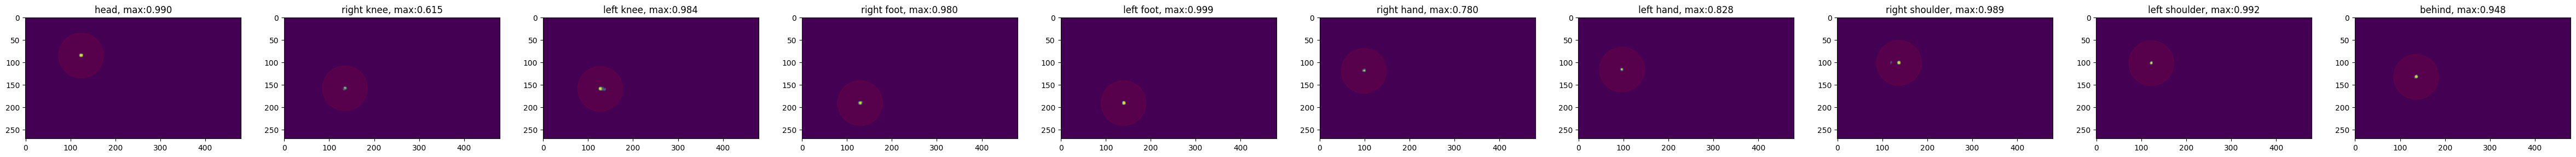

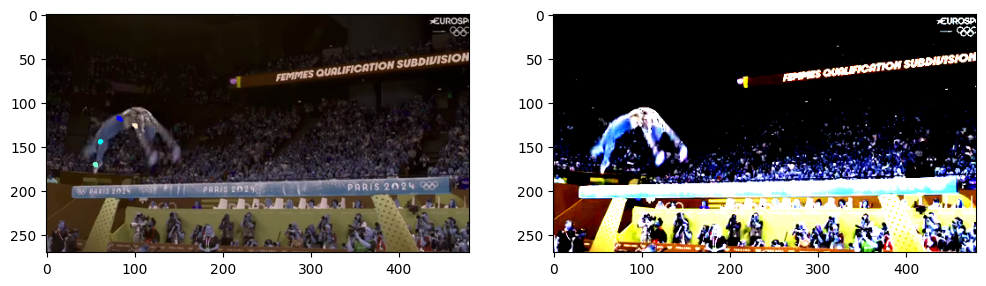

[[[           nan            nan 5.59556298e-03]
  [5.74263992e+01 1.41471252e+02 4.24736172e-01]
  [6.13490028e+01 1.44292877e+02 7.48533845e-01]
  [5.60534554e+01 1.70639923e+02 9.21347260e-01]
  [           nan            nan 6.39280491e-03]
  [           nan            nan 1.60370752e-01]
  [1.49439056e+02 1.51152740e+02 3.81810039e-01]
  [9.73818436e+01 1.29740494e+02 6.06832743e-01]
  [1.00903893e+02 1.26220116e+02 8.83449912e-01]
  [8.30385208e+01 1.18500359e+02 8.21045518e-01]]]
frame 2847


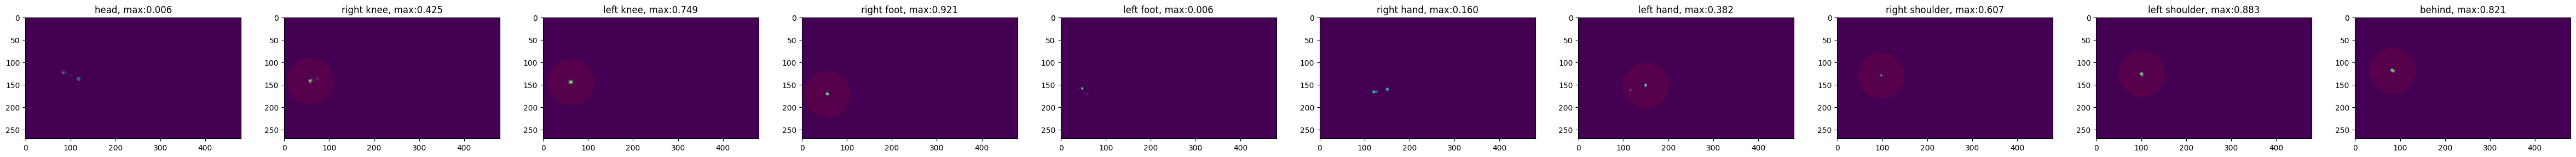

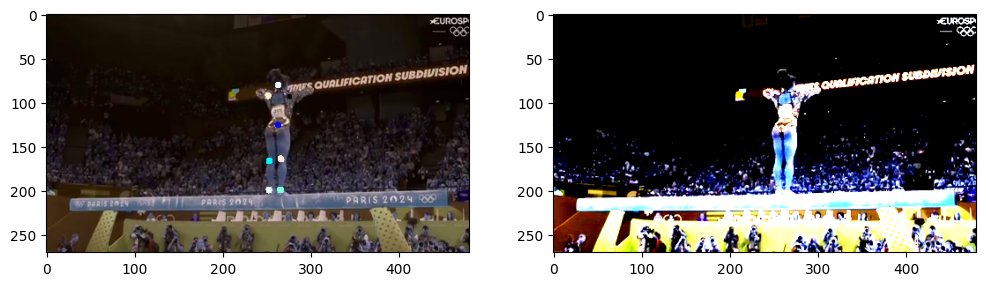

[[[2.63026978e+02 7.99622040e+01 9.94412720e-01]
  [2.66051025e+02 1.63896210e+02 9.94472563e-01]
  [2.52893799e+02 1.66004883e+02 9.99362409e-01]
  [2.65658691e+02 1.98766174e+02 9.97549474e-01]
  [2.52484741e+02 1.99100174e+02 9.97673094e-01]
  [           nan            nan 7.42095814e-04]
  [           nan            nan 2.94345059e-03]
  [2.75989746e+02 9.31404572e+01 8.65351617e-01]
  [2.51546127e+02 9.23243942e+01 9.71606910e-01]
  [2.62982849e+02 1.25229691e+02 9.07602847e-01]]]
frame 3222


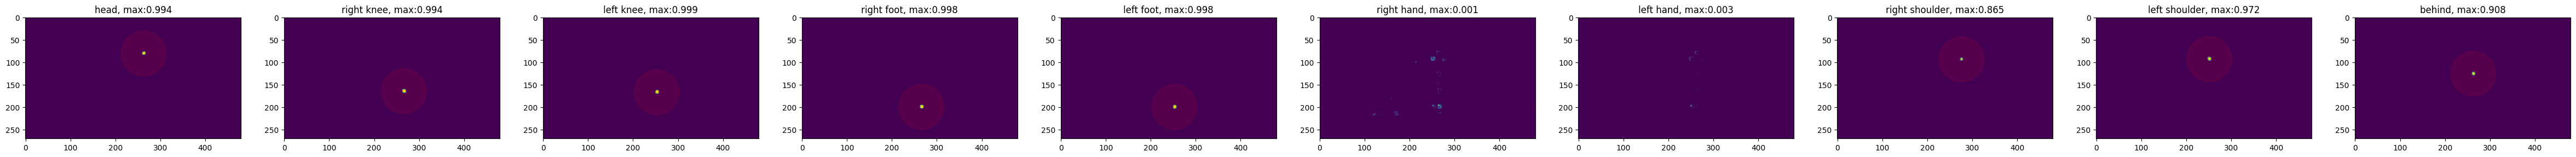

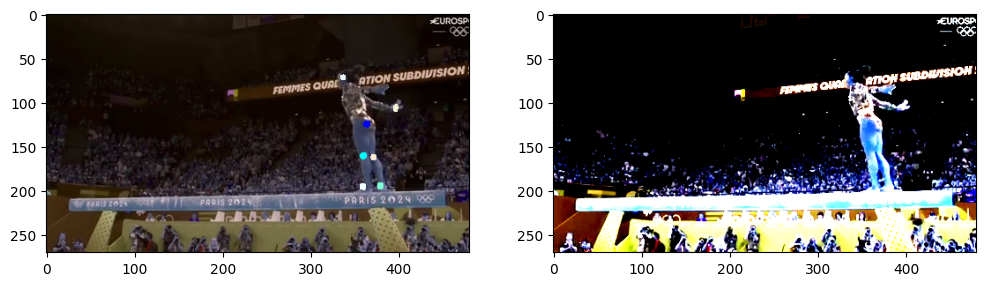

[[[3.36470093e+02 7.13811035e+01 9.42846715e-01]
  [3.71181000e+02 1.61780365e+02 9.63930368e-01]
  [3.59697449e+02 1.60467361e+02 9.94589925e-01]
  [3.79016205e+02 1.94731339e+02 9.99728858e-01]
  [3.59169525e+02 1.95377502e+02 9.98669386e-01]
  [3.96263733e+02 1.05992058e+02 9.26167846e-01]
  [           nan            nan 1.16302527e-01]
  [           nan            nan 2.59126886e-03]
  [           nan            nan 1.23117253e-01]
  [3.63593597e+02 1.24449219e+02 9.71374571e-01]]]


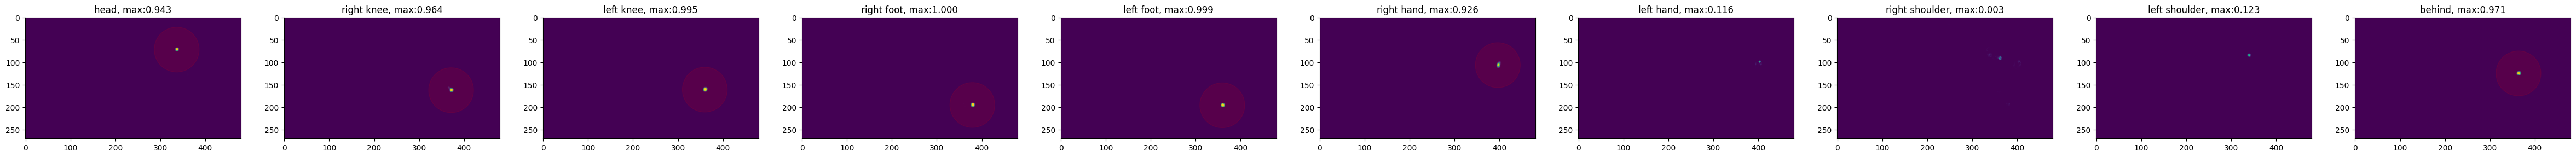

In [23]:
BGR2RGBTransformation=False

detector = CoordinatesFromSegmentationMask()

cap = cv2.VideoCapture(video_fn)
if (cap.isOpened()== False):
    raise ValueError("Error opening video file")

video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Number of frames in {}: {}".format(video_fn,video_length))

n = 10
sel_frames = np.random.choice(np.arange(video_length),size=n, replace=False)
sel_frames.sort()


for i in sel_frames:
    print("frame",i)
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)

    ret, image = cap.read()

    if ret == False:
        raise ValueError("Error reading video frame")

    input = image.astype(np.float32)
    if BGR2RGBTransformation:
        input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)

    normInput = valTransform(image=input)["image"] # normalize

    # transform to torch tensor, send to gpu, permute the dimensions and unsqueeze to make a batch
    input = torch.tensor(normInput).to(DEVICE).permute(2,0,1).unsqueeze(0).float()

    # model prediction
    output = torch.sigmoid(model(input))
    # batch to image, move to cpu memory, transform to numpy array
    output = output.to("cpu").detach().numpy()

    # draw output onto image
    outputThreshold = (output[0]>0.5).astype("float")

    for j in range(output.shape[1]): # body parts
        idx=(outputThreshold[j]==1.0)
        for c in range(3):
            image[idx,c]=project.object_colors[j][c]

    fig, ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].imshow(image)
    ax[1].imshow(normInput)
    plt.show()



    fig, ax = plt.subplots(1,output.shape[1],figsize=((output.shape[1])*6,6))
    for j in range(output.shape[1]):
        ax[j].imshow(output[0,j])
        ax[j].set_title("{}, max:{:0.3f}".format(project.object_list[j],output[0,j].max()))

    coord = detector.detect(output) # coord has shape batchsize,objects,3
    for j in range(coord.shape[1]):
        circle1 = plt.Circle((coord[0,j,0], coord[0,j,1]), 50, color='r',alpha=0.1)
        ax[j].add_patch(circle1)


    print(coord)


cap.release()